# COMP90051 Project 2
**Name:** *Youran Zhou*

**Student ID:** *991504*

In [35]:
# You can add additional imports here
import numpy as np
from matplotlib import pyplot as plt
import os
import random
from sklearn.model_selection import train_test_split
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import collections
from scipy.cluster.hierarchy import to_tree,ClusterNode,linkage

In [36]:
import warnings
warnings.filterwarnings('ignore')

## 0. Loading the dataset

In [37]:
# do not edit this cell
# load the data files (download from the LMS)
embedded_images = np.load('images.npy')
labels = np.load('labels.npy')

# split into pool & testing
X_pool, X_test, y_pool, y_test = train_test_split(embedded_images, labels, 
                                                  test_size=0.5, random_state=1234, shuffle=True)

# sample a seed set
np.random.seed(1234)
label2id = defaultdict(list)
for i, label in enumerate(y_pool):
    label2id[label].append(i)
seed_set = []
for label, ids in label2id.items():
    seed_set.extend(np.random.choice(ids, size=10, replace=False))

In [9]:
seed_pool = X_pool[seed_set]
seed_pool_label = y_pool[seed_set]

In [10]:
unlabelled_set = [x for x in list(range(0,len(X_pool))) if x not in seed_set]

unlabelled_pool = X_pool[unlabelled_set]
unlabelled_label = y_pool[unlabelled_set]

In [378]:
unique, counts = np.unique(y_pool, return_counts=True)

print(np.asarray((unique, counts)).T)

[['Alphabet_of_the_Magi' '200']
 ['Anglo-Saxon_Futhorc' '302']
 ['Arcadian' '234']
 ['Armenian' '416']
 ['Asomtavruli_(Georgian)' '390']
 ['Balinese' '252']
 ['Bengali' '452']
 ['Blackfoot_(Canadian_Aboriginal_Syllabics)' '136']
 ['Braille' '263']
 ['Burmese_(Myanmar)' '338']
 ['Cyrillic' '331']
 ['Early_Aramaic' '226']
 ['Futurama' '265']
 ['Grantha' '454']
 ['Greek' '237']
 ['Gujarati' '473']
 ['Hebrew' '221']
 ['Inuktitut_(Canadian_Aboriginal_Syllabics)' '145']
 ['Japanese_(hiragana)' '507']
 ['Japanese_(katakana)' '480']
 ['Korean' '404']
 ['Latin' '292']
 ['Malay_(Jawi_-_Arabic)' '404']
 ['Mkhedruli_(Georgian)' '409']
 ['N_Ko' '331']
 ['Ojibwe_(Canadian_Aboriginal_Syllabics)' '128']
 ['Sanskrit' '410']
 ['Syriac_(Estrangelo)' '229']
 ['Tagalog' '162']
 ['Tifinagh' '549']]


## 1. Applying logistic regression

In [28]:
def train_logistic_regression(X, y, **args):
    """
    Train a logistic regression model on dataset (X, y) and return trained model.
    X: matrix of real values, size n x d
    y: vector of string labels, size n
    args: optional arguments e.g., for hyper-parameters
    """
    model = LogisticRegression(**args).fit(X,y)
    return model

In [29]:
def evaluate_logistic_regression_accuracy(Xt, yt, model):
    """
    Apply logistic regression prediction on dataset Xt and evaluate accuracy against yt,
    returing the accuracy results as a scalar.
    Xt: matrix of real values, size m x d
    yt: vector of string labels, size m
    """
    score = model.score(Xt,yt)

    return score

In [381]:
# Train Models
full_pool_LR= train_logistic_regression(X_pool,y_pool)
seed_pool_LR= train_logistic_regression(seed_pool,seed_pool_label)

In [382]:
full_pool_train_acc = evaluate_logistic_regression_accuracy(X_pool,y_pool,full_pool_LR)
full_pool_test_acc = evaluate_logistic_regression_accuracy(X_test,y_test,full_pool_LR)

print("Train Accuracy for full pool: ",full_pool_train_acc)
print("Test Accuracy for full pool: ",full_pool_test_acc)

Train Accuracy for full pool:  0.66701244813278
Test Accuracy for full pool:  0.5640041493775934


In [383]:
seed_pool_train_acc = evaluate_logistic_regression_accuracy(seed_pool,seed_pool_label,seed_pool_LR)
seed_pool_test_acc = evaluate_logistic_regression_accuracy(X_test,y_test,seed_pool_LR)

print("Train Accuracy for seed pool: ",seed_pool_train_acc)
print("Test Accuracy for seed pool: ",seed_pool_test_acc)

Train Accuracy for seed pool:  1.0
Test Accuracy for seed pool:  0.316804979253112


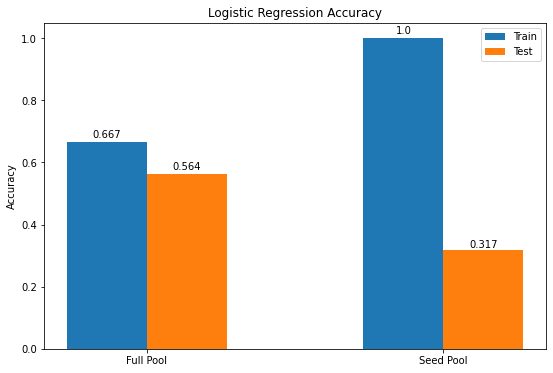

In [384]:
N = 2
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure(figsize = (9,6))
ax = fig.add_subplot(111)

train_vals = [full_pool_train_acc,seed_pool_train_acc]
rects1 = ax.bar(ind, train_vals, width)
test_vals = [full_pool_test_acc,seed_pool_test_acc]
rects2 = ax.bar(ind+width, test_vals, width)

ax.set_ylabel('Accuracy')
ax.set_xticks(ind+width/2)
ax.set_xticklabels( ('Full Pool', 'Seed Pool') )
ax.legend( (rects1[0], rects2[0]), ('Train', 'Test'),loc = 1 )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.01*h, round(h,3),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
plt.title("Logistic Regression Accuracy")


plt.show()

## 2. Active learning framework with Random selection

In [30]:
def random_select(X, model):
    """
    Given an unlabelled dataset X, a matrix of n x d, and a model (not used)
    returns a vector of scores of length n. Each entry reflects the priority 
    of the corresponding instance. Higher means better.
    """
    score = [random.uniform(0, 1) for i in range(len(X))]

    return score

In [31]:
def pool_based_active_learning(X_pool, y_pool, seed_ids,
                               train_func, select_func,
                               max_size, batch_size, **args):
    """
    Perform an active learning simulation, which starts by training on a seed set,
    then iteratively applies the selection function to rank instances in the pool,
    selects the top few instances which are included into the training set and the
    process repeats. 
        X_pool: matrix of n x d
        y_pool: vector of string labels, size n
        seed_ids: initial labelled set set, as a list of indices [0..n-1] into pool
        train_func: function which given (X, y, optional args) returns a trained model
        select_func: function which given (X, optional args) returns a sequence of scores
        max_size: stopping condition for active learning, when labelled data reaches given size
        batch_size: number of instances to be labelled in each iteration
        args: optional arguments passed to training and selection function
    returns the sequence of trained models 
    """
    
    L_X = X_pool[seed_ids]
    L_y = y_pool[seed_ids]
    
    modellist = []
    
    pbar = tqdm(total = (max_size-len(L_X))/batch_size)
    
    while len(L_X) <= max_size:

        
        #U_ids = [x for x in list(range(0,len(X_pool))) if x not in seed_ids]
        U_ids = np.setdiff1d(list(range(0,len(X_pool))), seed_ids)
        
        U_X = X_pool[U_ids]
        U_y = y_pool[U_ids]
        
        #print(len(U_X))

        model = train_func(L_X,L_y,**args)
        score = select_func(U_X,model)
        
        r = sorted(range(len(score)), key=lambda k: score[k],reverse=True)[:batch_size]

        try:
            modellist.append([model[1],len(L_X)])

        except:
            modellist.append([model,len(L_X)])
 

        L_X = np.append(L_X, U_X[r],axis = 0)
        L_y = np.append(L_y, U_y[r],axis = 0)
        
        seed_ids = seed_ids + list(U_ids[r])

        pbar.update(1)
        
    pbar.close()
    
    return modellist

In [32]:
batch = 60
max_size = 3000
models_random = pool_based_active_learning(X_pool, y_pool, seed_set, 
                                    train_logistic_regression, random_select, 
                                    max_size, batch,max_iter = 100)




 19%|█▉        | 563/3000 [32:39<2:21:21,  3.48s/it]
Exception ignored in: <function tqdm.__del__ at 0x0000027584468CA0>
Traceback (most recent call last):
  File "E:\python\lib\site-packages\tqdm\std.py", line 1145, in __del__
    self.close()
  File "E:\python\lib\site-packages\tqdm\notebook.py", line 275, in close
    self.disp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'disp'



  2%|▏         | 1/45.0 [00:00<00:26,  1.64it/s]


  4%|▍         | 2/45.0 [00:01<00:21,  1.99it/s]


  7%|▋         | 3/45.0 [00:01<00:21,  1.94it/s]


  9%|▉         | 4/45.0 [00:01<00:19,  2.08it/s]


 11%|█         | 5/45.0 [00:02<00:19,  2.07it/s]


 13%|█▎        | 6/45.0 [00:03<00:20,  1.92it/s]


 16%|█▌        | 7/45.0 [00:03<00:20,  1.89it/s]


 18%|█▊        | 8/45.0 [00:04<00:19,  1.90it/s]


 20%|██        | 9/45.0 [00:04<00:18,  1.90it/s]


 22%|██▏       | 10/45.0 [00:05<00:19,  1.81it/s]


 24%|██▍       | 11/45.0 [00:05<00:18,  1.84it/s]


 27%|██▋       

In [390]:
accuracy = [evaluate_logistic_regression_accuracy(X_test,y_test,model[0]) for model in models_random]
samples = [model[1] for model in models_random]

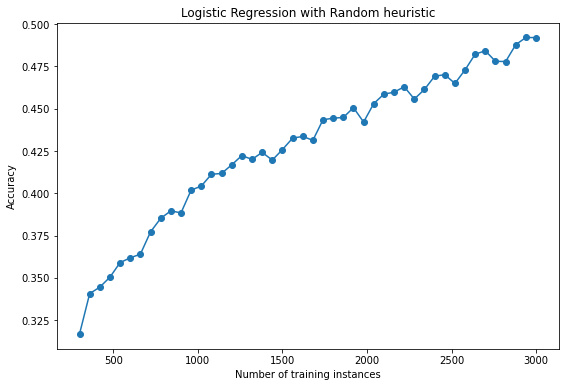

In [391]:
fig = plt.figure(figsize = (9,6))
ax = fig.add_subplot(111)

ax.plot(samples,accuracy,"o-")

ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of training instances')
plt.title("Logistic Regression with Random heuristic")


plt.show()

## 3. Uncertainty sampling

In [392]:
def ENTROPY(probs):
    """
    Given the an array of probability, return the entropy of the            probabilities
    """
    return -probs.dot(np.log2(probs))

def logistic_regression_entropy_select(X, model, **args):
    """
    Given an unlabelled dataset X, a matrix of n x d, and a discriminative model 
    P(y|x), returns a vector of n entropy values.
    """
    probs = model.predict_proba(X)
    
    result = np.apply_along_axis(ENTROPY, 1, probs)
    
    return result


In [393]:
models_us = pool_based_active_learning(X_pool, y_pool, seed_set, 
                                 train_logistic_regression, 
                                 logistic_regression_entropy_select, 
                                 max_size, batch,max_iter = 100)

46it [00:43,  1.06it/s]


In [394]:
accuracy = [evaluate_logistic_regression_accuracy(X_test,y_test,model[0]) for model in models_us]
samples = [model[1] for model in models_us]

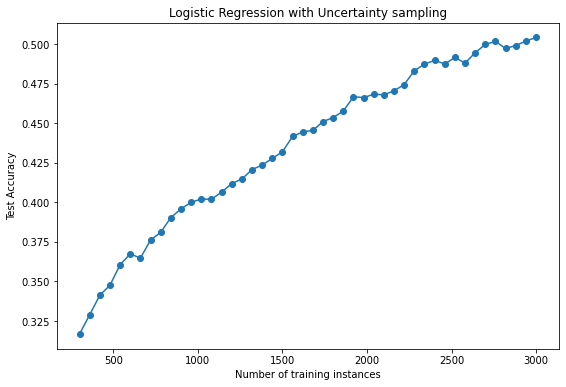

In [395]:
fig = plt.figure(figsize = (9,6))
ax = fig.add_subplot(111)

ax.plot(samples,accuracy,"o-")

ax.set_ylabel('Test Accuracy')
ax.set_xlabel('Number of training instances')
plt.title("Logistic Regression with Uncertainty sampling")


plt.show()

## 4. Query by committee

In [406]:
def query_by_committee_vote_entropy(X, model, **args):

    result = [clf.predict(X) for clf in model[0]]

    n = len(model[0])

    vote = [list(collections.Counter(x).values()) for x in zip(*result)]

    vote_entropy = [sum([(freq/n)*np.log2(freq/n) for freq in instance])*(-1) for instance in vote]


    return vote_entropy


def query_by_committee_soft_vote_entropy(X, model, **args):
    
    result = [clf.predict_proba(X) for clf in model[0]]

    n = len(model[0])

    zipped = [x for x in zip(*result)]
    prob_list = [(instance[1] + instance[0])/n for instance in zipped]

    soft_vote_entropy = np.apply_along_axis(ENTROPY, 1, prob_list)

    return soft_vote_entropy


def query_by_committee_KL(X, model, **args):
    result = [clf.predict_proba(X) for clf in model[0]]
    n = len(model[0])

    zipped = [x for x in zip(*result)]
    committee = [(instance[1] + instance[0])/n for instance in zipped]

    KL = [sum([sum(member*np.log2(member/committee[index])) for member in zipped[index]])/n  for index in range(len(X))]


    return KL

In [407]:
def train_committee(X, y,ensemble_size = 2, **args):

    random.seed(1)
    index = range(len(X))

    bagging_models = []
    for i in range(ensemble_size):
        bootstrap_index = random.choices(index, k = len(X))
        bagging_models.append(train_logistic_regression(X[bootstrap_index],y[bootstrap_index],**args))
    
    lr_model = train_logistic_regression(X, y,**args)

    return [bagging_models,lr_model]

In [409]:
models_ve = pool_based_active_learning(X_pool, y_pool, seed_set, 
                                 train_committee, 
                                 query_by_committee_vote_entropy, 
                                 max_size, batch, max_iter = 100)

models_sve = pool_based_active_learning(X_pool, y_pool, seed_set, 
                                 train_committee, 
                                 query_by_committee_soft_vote_entropy, 
                                 max_size, batch, max_iter = 100)


models_kl = pool_based_active_learning(X_pool, y_pool, seed_set, 
                                 train_committee, 
                                 query_by_committee_KL, 
                                 max_size, batch, max_iter = 100)


  0%|          | 0/45.0 [00:00<?, ?it/s]
  2%|▏         | 1/45.0 [00:01<01:05,  1.50s/it]
  4%|▍         | 2/45.0 [00:03<01:07,  1.56s/it]
  7%|▋         | 3/45.0 [00:04<01:07,  1.61s/it]
  9%|▉         | 4/45.0 [00:06<01:07,  1.65s/it]
 11%|█         | 5/45.0 [00:08<01:07,  1.68s/it]
 13%|█▎        | 6/45.0 [00:09<01:06,  1.70s/it]
 16%|█▌        | 7/45.0 [00:11<01:06,  1.74s/it]
 18%|█▊        | 8/45.0 [00:13<01:05,  1.76s/it]
 20%|██        | 9/45.0 [00:15<01:04,  1.79s/it]
 22%|██▏       | 10/45.0 [00:17<01:04,  1.85s/it]
 24%|██▍       | 11/45.0 [00:19<01:03,  1.87s/it]
 27%|██▋       | 12/45.0 [00:21<01:03,  1.91s/it]
 29%|██▉       | 13/45.0 [00:23<01:01,  1.92s/it]
 31%|███       | 14/45.0 [00:25<00:59,  1.92s/it]
 33%|███▎      | 15/45.0 [00:27<00:58,  1.93s/it]
 36%|███▌      | 16/45.0 [00:29<00:57,  1.97s/it]
 38%|███▊      | 17/45.0 [00:31<00:56,  2.00s/it]
 40%|████      | 18/45.0 [00:33<00:54,  2.03s/it]
 42%|████▏     | 19/45.0 [00:35<00:53,  2.07s/it]
 44%|████▍     | 

In [410]:
accuracy_ve = [evaluate_logistic_regression_accuracy(X_test,y_test,model[0]) for model in models_ve]
accuracy_sve = [evaluate_logistic_regression_accuracy(X_test,y_test,model[0]) for model in models_sve]
accuracy_kl = [evaluate_logistic_regression_accuracy(X_test,y_test,model[0]) for model in models_kl]

samples = [model[1] for model in models_ve]

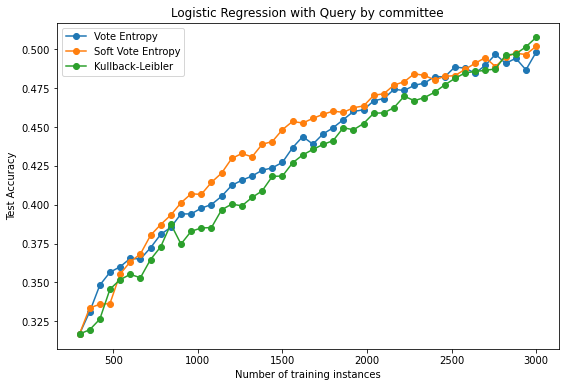

In [411]:
fig = plt.figure(figsize = (9,6))
ax = fig.add_subplot(111)

ax.plot(samples,accuracy_ve,"o-",label = "Vote Entropy")
ax.plot(samples,accuracy_sve,"o-",label = "Soft Vote Entropy")
ax.plot(samples,accuracy_kl,"o-",label = "Kullback-Leibler")


ax.set_ylabel('Test Accuracy')
ax.set_xlabel('Number of training instances')
plt.title("Logistic Regression with Query by committee")
plt.legend()

plt.show()

## 5. Hierarchical sampling

In [43]:
class Hierarchical_Sampling(object):
    """
    Construct a Hierarchical sampling class.

    """
    def __init__(self,y,linkage):
        """
        Initialize the Hierarchical sampling.
        Given the training set X and its Label y, 
        return the all the implementation methods.

            X: Training Data, size n * d
            y: The label of the Training Data, size n
        """
        keys = set(y)
        # Build the Hierarchical Tree Structure
        self.rootnode,self.nodelist  = to_tree(linkage,rd = True)

        # Add Parent node to each node, earier for future implementation
        self.rootnode.parent = None
        for node in self.nodelist:
            if node.get_left():
                node.left.parent = node
            if node.get_right():
                node.right.parent = node

        # Record the number of class n
        self.n_labels = len(set(y))
        # the number of node in the tree
        self.n_nodes = len(self.nodelist)


        ## Update Empirical count and probabilities
        # Record the number of point sampled from node V of each class
        self.label_count = np.zeros((len(self.nodelist),self.n_labels))
        # Record the fraction of label l in points sampled from Subtree V
        self.proba = np.zeros((len(self.nodelist),self.n_labels))
                
        # Record the number of sampled time
        self.n = np.zeros(len(self.nodelist))


        ## Update Admissible and Score
        # Record if the node is admissible or not
        self.admissible = np.array(np.array([False]*len(self.nodelist)*self.n_labels).reshape(len(self.nodelist),self.n_labels))

        # Record score for each node
        self.score = np.zeros(len(self.nodelist))


        ## Prune and assign Labels
        # Record if achieve score/shoud it be pruned
        self.prune = np.zeros(len(self.nodelist))
        # Record the labels
        self.label = np.zeros(len(self.nodelist))


        # Record the Lower bound and Upper Bound
        self.upper = np.zeros((len(self.nodelist),self.n_labels))
        self.lower = np.zeros((len(self.nodelist),self.n_labels))    
   
    def select(self,P,selection_type="Lower"):
        """
        Selection Function, use Active Sampling as selection crieria. Return a selected node.

            P: Current pruning of tree, size p * 1 (A list of node index)
            selection_type: A string, indicates use Upper bound or Lower bound as the selection criteria. Default is Upper.
        """

        # Choose use Upper Bound or use Lower Bound
        if selection_type == "Upper":
            bound = self.upper[P]
        else:
            bound = self.lower[P]

        L = self.label[P].astype(int)
        weight = np.array([self.nodelist[node].count for node in P])
        bound = bound[np.arange(len(bound)),L]
        count = weight *(1-bound)
        return random.choices(P,weights = count/sum(count))[0]
    

    def leaves(self, node,leaf_list = None):
        """
        Get all the leaf node from a given node recursively. 
        Return a list of leaf node.

            node: Current root node
            leaf_list: A list used to store all the found leaf node.
        """
        node = self.nodelist[node]
        if not leaf_list:
            leaf_list = []
        if node.is_leaf():
            leaf_list.append(node)
            return leaf_list
        else:
            leaf_list = self.leaves(node.left.id,leaf_list)
            leaf_list = self.leaves(node.right.id,leaf_list)
            
            return leaf_list

    def rand_pick(self,node,queries,leaf_list=None):
        """
        Query node from the list of leaf node of the given subtree randomly. 
        If a node has been queryed, then it will random select one node from the queries list.
        Return a selected node z

            node: Current root node
            queries: A list that record all queryed node
            leaf_list: A list used to store all the found leaf node.
        """
        
        leaves_list = self.leaves(node)
        leaves_id = np.array([leaf.id for leaf in leaves_list])
        queries = np.array(queries)

        not_query = np.setdiff1d(leaves_id,queries)
        if len(not_query) == 0:
            return self.nodelist[random.choice(queries)]
        else:
            return random.choice(leaves_list)


    def empirical_counts_proba(self,z,v,label):
        """
        Update the number of points queryed from node v and the fraction of label.

            z: Current node
            v: subroot node
            label: queryed z's label
        """

        if not isinstance(z,ClusterNode):
            z = self.nodelist[z]
        if not isinstance(v,ClusterNode):
            v = self.nodelist[v] 
 
        # make sure we are count all the leaf node under the subroot node v
        while z and z.id <= v.id:
            # Use Label count to record the label of each queryed node
            self.label_count[z.id][label]+=1
            # Record the number that the node has been counted
            self.n[z.id] +=1
            z = z.parent

        self.n = self.n.reshape((len(self.n), 1))      

        self.proba = self.label_count/self.n 


    def update_admissible(self,beta = 2):
        """
        Update the admissible (Node, label) pair. 
        The admissible is matrix that contains True and False.

            beta: parameter Beta with default value:2 
        """
        # Calculate the confidence interval of node v with label l
        delta = 1/self.n + np.sqrt(self.proba*(1-self.proba)/self.n)
        lower = np.fmax(self.proba-delta,0)
        upper = np.fmin(self.proba+delta,1)
        
        # Lemma 1
        for l in np.arange(self.n_labels):
            upper_lp = np.delete(upper,l,axis = 1)
            self.admissible[:,l] = np.all((1-lower[:,l][:,None])<beta*(1-upper_lp),axis = 1)
        
        # Empeirical estimate of the error
        self.E_vl = 1-self.proba
        self.E_vl[~self.admissible] = 1
        
        # Record the Upper Bound and Lower Bound to calculate select function
        self.upper = upper
        self.lower = lower
    

    def update_score(self):
        """
        Pruning the labeling of T_v achieving score. The score is use
        to select a good pruning
        """
        
        # Traversal all the node of the tree 
        for i in range(len(self.nodelist)):
            node = self.nodelist[i]

            # if a node is a leaf node, estimated error of pruning is used
            # leaf node should not be pruned
            if node.is_leaf():
                self.score[i] = np.nanmin(self.E_vl[i])
                self.prune[i] = False
            else:
                # For admissible pair:
                # check the estimated error and the estimated error of its children 
                # if the children's score is smaller, then the node should be pruned
                if self.admissible[i,:].any():
                    
                    a_score = (node.left.count/node.count) * self.score[node.left.id]
                    b_score = (node.right.count/node.count) * self.score[node.right.id]
                    if a_score+b_score < np.nanmin(self.E_vl[i]):
                        self.score[i] = a_score+b_score
                        self.prune[i] = True
                    else:
                        self.score[i] = np.nanmin(self.E_vl[i])
                        self.prune[i] = False
                else:
                    # For non-admissible pair, simplely use the score
                    self.score[i] = np.nanmin(self.E_vl[i])
                    self.prune[i] = False

    def recursively_update_label(self,node,P):
        """
        Recursively update the label of each node in current purne P

            node: Node from P
            P: Node to show the label 
        """

        if not isinstance(node, ClusterNode):
            node = self.nodelist[node]
        if not isinstance(P, ClusterNode):
            P = self.nodelist[P]

        if node.is_leaf():
            self.label[node.id] = self.label[P.id]
        else:
            self.recursively_update_label(node.left,P)
            self.recursively_update_label(node.right,P)

    def update_L_P(self,P):
        """
        Update the new pruning list P_prime, using the record self.prune from pervious steps.
        return the new pruned list P_prime (list of node id)

            P: current Prune, a list of node id
        """
        
        P_prime = []
        for i in P:
            node = self.nodelist[i]

            # if the node is recorded to be pruned,than it will be pruned and left its children nodes
            if self.prune[i]:

                label = np.where(self.admissible[i,:])[0][0]
                P_prime.append(node.left.id)
                P_prime.append(node.right.id)
                self.label[node.left.id] = label
                self.label[node.right.id] = label
            else:
                P_prime.append(i)
                self.label[node.id] = np.nanargmin(self.E_vl[i])
        # Assign all thelable for the P_prime and update its labels       
        for p in P_prime:
            self.recursively_update_label(p,p)
        return P_prime

In [21]:
def Cluster_adaptive_active_learning(X,y,max_size,selection_type = "Lower",beta = 2.0):
    """
    Perform Cluster adaptive active learning using Hierarchical Sampling stratagy, 
    a defined Hierarchical sampling class will be use in this function. 
    All the implementation function is from the Hierarchical sampling class included: 
    select(),rand_pick(),empirical_counts_proba(), update_admissible(), update_score() and
    update_L_P(). A list of queries will be recorded and returned. 
    The lenth of the queries will be the stopping criteria of the while loop which keep 
    calling the hierarchical sampling.

        X_pool: matrix of n x d
        y_pool: vector of string labels, size n
        max_size: interger, stopping condition for active learning, ]
                  when number of queries reaches the given size
        beta: beta value use calculate the admissiblity with default value 2.0

    returns the list of pruned list and the list of queries  
    """
    P_list = []
    labelset, y = np.unique(y, return_inverse=True)
    X_linkage = linkage(X,method='average')
    print("Finish building the hierarchical linkage..")
    Tree = Hierarchical_Sampling(y,X_linkage)
    P = np.array([Tree.rootnode.id])
    queries = []
    pbar = tqdm(total=max_size)
    while len(queries) < max_size:
        v = Tree.select(P,)    
        z = Tree.rand_pick(v,queries)
        queries.append(z.id)
        label = y[z.id] 
        Tree.empirical_counts_proba(z,v,label)
        Tree.update_admissible(beta)
        Tree.update_score()
        P = Tree.update_L_P(P)
        P_list.append(P)
        pbar.update(1)
    #print(P_list)
    pbar.close()
    return queries, P_list

In [44]:
Query_Upper, P_Upper = Cluster_adaptive_active_learning(X_pool,y_pool,"Upper",max_size,2)
Query_Lower, P_Lower = Cluster_adaptive_active_learning(X_pool,y_pool,"Lower",max_size,2)

100%|██████████| 3000/3000 [16:48<00:00,  2.98it/s]


In [40]:
upper_acc_list = []
sample_list = []
for i in range(300,max_size+60,60):
    index = Query_Upper[:i]
    sample_list.append(len(index))
    lr = LogisticRegression().fit(X_pool[index],y_pool[index])
    upper_acc_list.append(lr.score(X_test[index],y_test[index]))

In [54]:
lower_acc_list = []
sample_list = []
for i in range(300,max_size+60,60):
    index = Query_Lower[:i]
    sample_list.append(len(index))
    lr = LogisticRegression().fit(X_pool[index],y_pool[index])
    lower_acc_list.append(lr.score(X_test[index],y_test[index]))

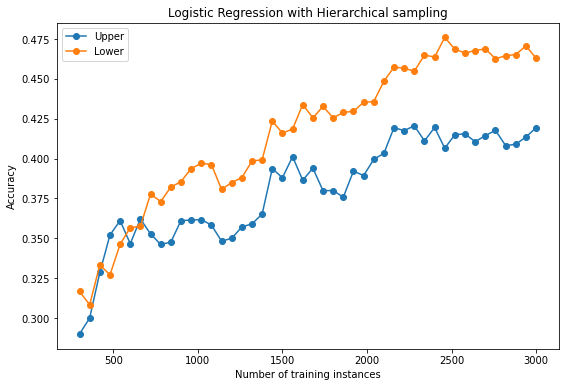

In [56]:
fig = plt.figure(figsize = (9,6))
ax = fig.add_subplot(111)

ax.plot(sample_list,upper_acc_list,"o-",label= "Upper")
ax.plot(sample_list,lower_acc_list,"o-",label= "Lower")

ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of training instances')
plt.legend()
plt.title("Logistic Regression with Hierarchical sampling")


plt.show()

In [52]:
len(acc_list)

92